In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
import xgboost as xgb
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [105]:
data = pd.read_csv('data_featured_4235_except_zeros.csv', index_col='Unnamed: 0') #drop(columns=['RedFighter', 'BlueFighter', 'Result'], axis=1)
# y = pd.read_csv('ufc-master-for-binary-classification.csv', index_col='Unnamed: 0')['Result']

In [68]:
data.columns

Index(['WeightClass', 'RedStance', 'BlueStance', 'Result', 'Age_diff',
       'Height_diff', 'Reach_diff', 'Weight_diff', 'Red_wins_loss_diff',
       'Blue_wins_loss_diff', 'Red_Blue_Wins_diff', 'Red_Blue_Loss_diff',
       'Red_Blue_wins_loss_diff', 'AvgSigStrLanded_diff', 'AvgSigStrPct_diff',
       'TDAvgLanded_diff', 'AvgTDPct_diff', 'AvgSubAtt_diff',
       'Red_Blue_curr_streak_diff'],
      dtype='object')

In [112]:
data = data.loc[:2200, :]
X = data.drop(['Result'], axis=1)
y = data['Result']

In [114]:
# X = X.iloc[:1900, :]
# y = y.iloc[:1900]


test_size = int(len(X)*0.1)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y)

In [72]:
y_train =np.array(y_train)
y_test =np.array(y_test)

In [115]:
# Масштабируйте данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### XGBoost

In [116]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    max_depth = trial.suggest_int('max_depth', 1, 16)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    gamma = trial.suggest_loguniform('gamma', 0.01, 10.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.2, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 10.0)

    # Создание модели
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, gamma=gamma,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Оценка модели
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=200)

# Вывод лучших гиперпараметров и результата
# print("Лучшие гиперпараметры:", study.best_params)
# print("Результат:", study.best_value)

# Создание модели с лучшими гиперпараметрами
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train_scaled, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_model.predict(X_test_scaled)
print("F1-мера модели с лучшими гиперпараметрами:", f1_score(y_test, y_pred, average='weighted'))
# Вывод параметров лучшей модели
print("Параметры лучшей модели:", best_model.get_params())

[I 2025-01-16 18:58:39,076] A new study created in memory with name: no-name-861b47de-7917-4f7c-913a-1487fe829837
[I 2025-01-16 18:58:39,258] Trial 0 finished with value: 0.5189873417721519 and parameters: {'max_depth': 13, 'learning_rate': 0.6286008153804608, 'n_estimators': 72, 'gamma': 0.012910760420193701, 'subsample': 0.9580338597596547, 'colsample_bytree': 0.2757064687989356, 'reg_alpha': 9.86717639238332, 'reg_lambda': 3.1114466754392236}. Best is trial 0 with value: 0.5189873417721519.
[I 2025-01-16 18:58:39,319] Trial 1 finished with value: 0.5106382978723404 and parameters: {'max_depth': 15, 'learning_rate': 0.013904003012652611, 'n_estimators': 78, 'gamma': 4.964643297634863, 'subsample': 0.7760695802498678, 'colsample_bytree': 0.40391219568177195, 'reg_alpha': 5.33797693316197, 'reg_lambda': 0.015991321265919033}. Best is trial 0 with value: 0.5189873417721519.
[I 2025-01-16 18:58:39,365] Trial 2 finished with value: 0.5066666666666667 and parameters: {'max_depth': 15, 'lea

F1-мера модели с лучшими гиперпараметрами: 0.6976298021719795
Параметры лучшей модели: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8469006011123846, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 3.166469996601548, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.059418596873823414, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 14, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 84, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 1.2259774252085858, 'reg_lambda': 0.0292510375687464, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.5647854957026887, '

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       110
           1       0.65      0.66      0.65        85

    accuracy                           0.70       195
   macro avg       0.69      0.69      0.69       195
weighted avg       0.70      0.70      0.70       195



Text(0.5, 23.52222222222222, 'predicted value')

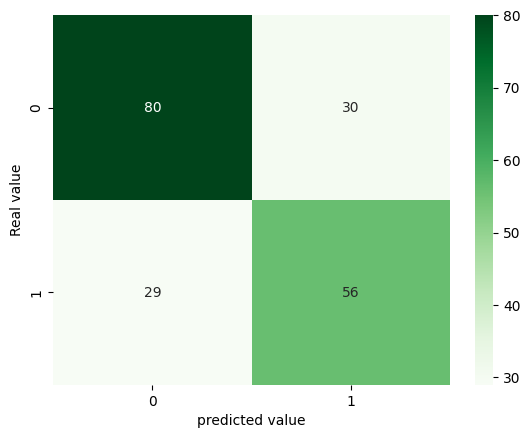

In [117]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### PyTorch

In [ ]:
y_train =np.array(y_train)
y_test =np.array(y_test)

In [169]:
# # Стандартизация данных
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
    
# Параметры модели
input_size = X_train_scaled.shape[1]
hidden_size = 128
num_classes = 2
learning_rate = 0.01
num_epochs = 50
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(model.parameters(), lr=learning_rate)

In [170]:
# Обучение модели
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.6824
Epoch [20/50], Loss: 0.5860
Epoch [30/50], Loss: 0.6204
Epoch [40/50], Loss: 0.4801
Epoch [50/50], Loss: 0.5723


In [171]:
# Оценка модели
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score: {f1:.4f}')

Accuracy: 0.6154
F1 Score: 0.6145


In [156]:
# Функция для аугментации данных
def augment_data(X, y, noise_level=0.05):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise
    y_augmented = y.copy()
    return X_augmented, y_augmented

# Аугментация тренировочных данных
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented, dtype=torch.float32)
# y_train_augmented_tensor = torch.tensor(y_train_augmented.values, dtype=torch.long)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/200], Loss: 0.6167
Epoch [20/200], Loss: 0.5442
Epoch [30/200], Loss: 0.5905
Epoch [40/200], Loss: 0.6320
Epoch [50/200], Loss: 0.6699
Epoch [60/200], Loss: 0.6913
Epoch [70/200], Loss: 0.5315
Epoch [80/200], Loss: 0.6860
Epoch [90/200], Loss: 0.6126
Epoch [100/200], Loss: 0.6845
Epoch [110/200], Loss: 0.6182
Epoch [120/200], Loss: 0.6709
Epoch [130/200], Loss: 0.5864
Epoch [140/200], Loss: 0.6215
Epoch [150/200], Loss: 0.6851
Epoch [160/200], Loss: 0.5181
Epoch [170/200], Loss: 0.6748
Epoch [180/200], Loss: 0.6814
Epoch [190/200], Loss: 0.7259
Epoch [200/200], Loss: 0.6286


In [157]:
# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after augmentation: {accuracy:.4f}')

    # Вычисление F1-меры
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after augmentation: {f1:.4f}')

Accuracy after augmentation: 0.6615
F1 Score after augmentation: 0.6583


Датасет + аугментированный датасет

In [168]:
# # Стандартизация данных
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 128
num_classes = 2
learning_rate = 0.03
num_epochs = 50
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Создание DataLoader для базовых данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Функция для аугментации данных
def augment_data(X,noise_level=0.04):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise  
    return X_augmented

# Аугментация тренировочных данных
X_train_augmented = augment_data(X_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented, dtype=torch.float32)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(model.parameters(), lr=learning_rate)

# Обучение модели на базовых данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на базовых данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on base data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on base data: {f1:.4f}')

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on augmented data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on augmented data: {f1:.4f}')

Epoch [10/50], Loss: 0.7641
Epoch [20/50], Loss: 0.5317
Epoch [30/50], Loss: 0.6124
Epoch [40/50], Loss: 0.6108
Epoch [50/50], Loss: 0.6143
Accuracy after training on base data: 0.6256
F1 Score after training on base data: 0.6216
Epoch [10/50], Loss: 0.6039
Epoch [20/50], Loss: 0.6596
Epoch [30/50], Loss: 0.6589
Epoch [40/50], Loss: 0.5944
Epoch [50/50], Loss: 0.5403
Accuracy after training on augmented data: 0.6256
F1 Score after training on augmented data: 0.6216
